In [1]:
import numpy as np
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
# load les données

fichier = open('villes.txt')
donnees = fichier.read()
villes = donnees.replace('\n', ',').split(',')

In [3]:
# preparation des données

# on rajoute le token . au début et en fin
for ville, i in zip(villes, range(len(villes))):
    villes[i] = '.' + ville + '.'

# création du vocabulaire
vocabulaire = []

for ville in villes:
    for c in ville:
        if c not in vocabulaire:
            vocabulaire.append(c)

vocabulaire = sorted(vocabulaire)
vocabulaire[0] = '.'
vocabulaire[3] = " "

# pour convertir char <-> int
char_to_int = {}
int_to_char = {}

for (c, i) in zip(vocabulaire, range(len(vocabulaire))):
    char_to_int[c] = i
    int_to_char[i] = c

In [4]:
# création du dataset

X = []
Y = []

context_len = 3

for ville in villes:
    context = [0] * context_len

    for ch in ville:
        X.append(context)
        Y.append(char_to_int[ch])

        context = context[1:] + [char_to_int[ch]]


X = torch.tensor(X) # (M, 3), int64
Y = torch.tensor(Y) # (M), int64

n1 = int(0.8*X.shape[0])

X_train = X[:n1]
X_test = X[n1:]

Y_train = Y[:n1]
Y_test= Y[n1:]

In [5]:
max = 0
for ville in villes:
    if len(ville) > max:
        max = len(ville)
print(max)

47


In [6]:
# X : (S, max, 44) avec S le nombre de séquences, max la longueur de la séquence la plus longue, 44=len(vocabulaire) donc padding nécessaire
# W [[1,2,56,3], 1] donne W_1 avec les séquences 1,2,56,3

X = torch.zeros((len(villes), max, 44))

for (ville, j) in zip(villes, range(len(villes))):
    X_ville = torch.zeros((max, 44))

    for i in range(max):    
        if i >= len(ville):
            ch_one_hot = F.one_hot(torch.tensor(char_to_int['.']), num_classes=44).to(dtype=torch.float64)
        else:
            ch_one_hot = F.one_hot(torch.tensor(char_to_int[ville[i]]), num_classes=44).to(dtype=torch.float64)

        X_ville[i] = ch_one_hot
    
    X[j] = X_ville

In [7]:
for i in range(100):
    ix = torch.randint(low=0, high=X.shape[0], size=(32,))
    

In [48]:
#todo : voir si on a aussi ce deuxième pic avec nos noms de villes générés

In [8]:
occurences_lens = [0] * 48

for ville in villes:
    occurences_lens[len(ville)] += 1

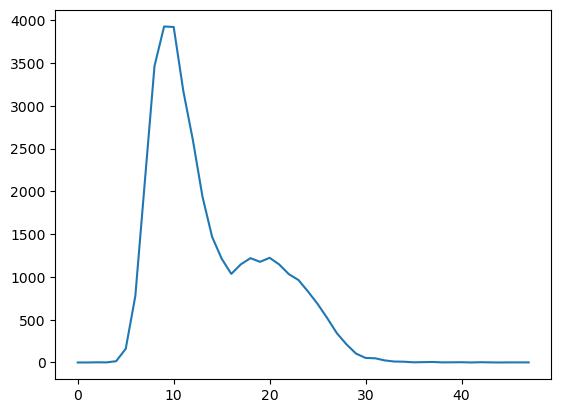

In [9]:
plt.plot(occurences_lens)

In [10]:
occurences_lens_dict = {}

for taille, occ in enumerate(occurences_lens):
    if occ>32:
        occurences_lens_dict[taille] = occ

In [11]:
X = {} #composé de tensors (S, taille, 44) avec S le nb de séquences ayant pour taille taille

for taille, occ in occurences_lens_dict.items():
    Xlen = torch.zeros((occ, taille, 44))
    compteur = 0

    for ville in villes:
        if len(ville) == taille:
            X_ville = torch.zeros((taille, 44))

            for i, ch in enumerate(ville):    
                ch_one_hot = F.one_hot(torch.tensor(char_to_int[ch]), num_classes=44).to(dtype=torch.float64)
                X_ville[i] = ch_one_hot

            Xlen[compteur] = X_ville
            compteur += 1
    
    X[taille] = Xlen

In [12]:
occurences_lens_dict

{5: 160,
 6: 777,
 7: 2125,
 8: 3465,
 9: 3926,
 10: 3920,
 11: 3173,
 12: 2598,
 13: 1937,
 14: 1469,
 15: 1213,
 16: 1035,
 17: 1147,
 18: 1219,
 19: 1176,
 20: 1223,
 21: 1145,
 22: 1032,
 23: 964,
 24: 829,
 25: 684,
 26: 519,
 27: 343,
 28: 213,
 29: 104,
 30: 53,
 31: 49}

In [13]:
probs_lens_dict = {}

for k in occurences_lens_dict.keys():
    probs_lens_dict[k] = occurences_lens_dict[k]/sum(occurences_lens_dict.values())

probs_lens_dict

{5: 0.004383801852156283,
 6: 0.021288837744533946,
 7: 0.05822236834895063,
 8: 0.0949367088607595,
 9: 0.10756753794728478,
 10: 0.10740314537782893,
 11: 0.08693627048057428,
 12: 0.07118198257438764,
 13: 0.053071401172666996,
 14: 0.04024878075510987,
 15: 0.033234697791659815,
 16: 0.02835771823113595,
 17: 0.03142637952764535,
 18: 0.03339909036111568,
 19: 0.03222094361334868,
 20: 0.03350868540741959,
 21: 0.031371582004493394,
 22: 0.028275521946408023,
 23: 0.026412406159241602,
 24: 0.022713573346484738,
 25: 0.018740752917968107,
 26: 0.014219957257931942,
 27: 0.009397775220560031,
 28: 0.005835936215683051,
 29: 0.0028494712039015837,
 30: 0.0014521343635267687,
 31: 0.0013425393172228615}

In [21]:
d_model = 64
mb_size = 32

In [22]:
Wu = torch.randn((44+d_model, d_model))/10
bu = torch.randn((d_model))/10

Wv = torch.randn((d_model, 44))/10
bv = torch.randn((44))/10

parameters = [Wu, bu, Wv, bv]

In [23]:
total_params = sum(p.numel() for p in parameters)
total_params

9836

In [24]:
for p in parameters:
    p.requires_grad = True

In [25]:
g = torch.Generator().manual_seed(42)
optim = torch.optim.AdamW(parameters, lr=0.0005, weight_decay=0.01, betas=(0.9, 0.99))

In [26]:
lossi = []

In [39]:
for _ in range(1000):
    #sample une taille en fonction des probas
    len_mb = list(probs_lens_dict.keys())[torch.multinomial(torch.tensor(list(probs_lens_dict.values()), dtype=torch.float32), num_samples=1, replacement=True, generator=g).item()]

    ix_mb = torch.randint(low=0, high=X[len_mb].shape[0], size=(mb_size,), generator=g)

    #forward
    loss = 0
    S = torch.ones((mb_size, d_model)) # (32, d_model)
    for t in range(0, len_mb-1):
        W_t = X[len_mb][ix_mb, t, :] # (32, 44)
        
        X_t = torch.cat([W_t, S], dim=1) # (32, 44+d_model)

        S = F.tanh(X_t @ Wu + bu) # (32, d_model)

        logits = S @ Wv + bv # (32, 44)

        targets = torch.argmax(X[len_mb][ix_mb, t+1, :], dim=1)
        loss += F.cross_entropy(logits, targets)

    loss = loss / (len_mb - 1)
    lossi.append(loss.item())

    optim.zero_grad()
    loss.backward()
    optim.step()

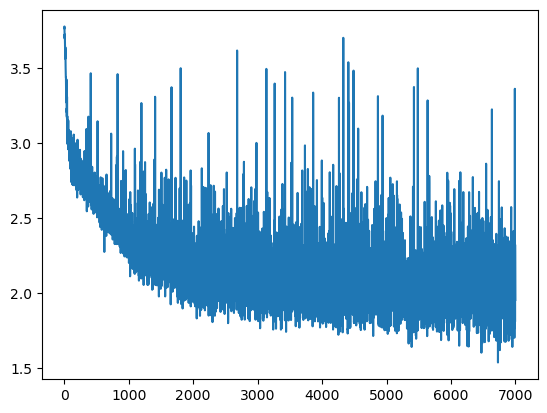

In [40]:
plt.plot(lossi)

In [111]:
total_loss = 0
total_seq_len = 0

with torch.no_grad():  # Pas besoin de calculer les gradients lors de l'évaluation
    for len_mb, tensor in X.items():  # Ici, je suppose que X est votre dataset d'entraînement
        for ix_mb in range(tensor.shape[0]):
            loss = 0
            S = torch.ones((1, d_model))  # Ici, le mini-batch a une taille de 1
            for t in range(0, len_mb-1):
                W_t = tensor[ix_mb:ix_mb+1, t, :]  # Récupère un sous-ensemble de taille 1 du mini-batch
                
                X_t = torch.cat([W_t, S], dim=1) 

                S = F.tanh(X_t @ Wu + bu) 

                logits = S @ Wv + bv 

                targets = torch.argmax(tensor[ix_mb:ix_mb+1, t+1, :], dim=1)
                loss += F.cross_entropy(logits, targets)
            
            total_loss += loss.item()
            total_seq_len += len_mb - 1  # Compte le nombre total de pas de temps

totalloss = total_loss / total_seq_len

In [112]:
totalloss

1.986338191039846

In [113]:
#sampling

g = torch.Generator().manual_seed(40 + 2)

for _ in range(10):

    nom = ""

    #forward
    S = torch.ones((1, d_model)) # (1, d_model)
    W_t = F.one_hot(torch.tensor(0), num_classes=44).view(1, 44)

    while True:
        X_t = torch.cat([W_t, S], dim=1) # (1, 44+d_model)

        S = F.tanh(X_t @ Wu + bu) # (1, d_model)

        logits = S @ Wv + bv # (1, 44)
        Y_t = F.softmax(logits, dim=1)

        next_id = torch.multinomial(Y_t, num_samples=1, replacement=True, generator=g).item()

        if next_id == 0:
            break

        W_t = F.one_hot(torch.tensor(next_id), num_classes=44).view(1, 44)
        nom += int_to_char[next_id]
    
    print(nom)

valladet
counsain-le-chédagne
borstay
ethaboin
iellafze
vaybey-mère
chaugly
attard
la jauziclonseine
le raudien
